<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!mkdir data
!gdown 1CVAQDuPOiwm8h9LJ8a_oOs6zOWS6EgkB
!gdown 1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe
!unzip -o test.zip -d data
!unzip -o train.zip -d data

!git clone https://github.com/Mamiglia/challenge.git

Streaming output truncated to the last 5000 lines.
  inflating: data/train/Images/478200744.jpg  
  inflating: data/train/Images/4615550262.jpg  
  inflating: data/train/Images/6101818492.jpg  
  inflating: data/train/Images/275169881.jpg  
  inflating: data/train/Images/2508843920.jpg  
  inflating: data/train/Images/256428765.jpg  
  inflating: data/train/Images/4735742933.jpg  
  inflating: data/train/Images/3628829949.jpg  
  inflating: data/train/Images/608453511.jpg  
  inflating: data/train/Images/180027584.jpg  
  inflating: data/train/Images/1801283994.jpg  
  inflating: data/train/Images/6681942245.jpg  
  inflating: data/train/Images/3479423813.jpg  
  inflating: data/train/Images/2341755936.jpg  
  inflating: data/train/Images/2814406547.jpg  
  inflating: data/train/Images/4342753575.jpg  
  inflating: data/train/Images/489773343.jpg  
  inflating: data/train/Images/6556869643.jpg  
  inflating: data/train/Images/4644327815.jpg  
  inflating: data/train/Images/4957517466.j

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm

from challenge.src.common import load_data, prepare_train_data, generate_submission

In [26]:
# Configuration
MODEL_PATH = "models/mlp_baseline.pth"
EPOCHS = 20
BATCH_SIZE = 256
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
class MLP(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1536, hidden_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

In [27]:
import torch.nn.functional as F

def train_model(model, train_loader, val_loader, device, epochs, lr):
    """Train the MLP model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)

            loss = F.mse_loss(outputs, y_batch)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = F.mse_loss(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best model (val_loss={val_loss:.6f})")

    return model


In [28]:
# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)
DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
y_train.shape[-1], X_val.shape[-1]

(125000,)
Train data: 125000 captions, 125000 images


(1536, 1024)

In [29]:
model = MLP().to(DEVICE)
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\n3. Training...")
model = train_model(model, train_loader, val_loader, DEVICE, EPOCHS, LR)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH))


   Parameters: 1,574,400

3. Training...


Epoch 1/20: 100%|██████████| 440/440 [00:02<00:00, 195.40it/s]


Epoch 1: Train Loss = 0.171807, Val Loss = 0.157777
  ✓ Saved best model (val_loss=0.157777)


Epoch 2/20: 100%|██████████| 440/440 [00:01<00:00, 232.34it/s]


Epoch 2: Train Loss = 0.153125, Val Loss = 0.155852
  ✓ Saved best model (val_loss=0.155852)


Epoch 3/20: 100%|██████████| 440/440 [00:01<00:00, 232.08it/s]


Epoch 3: Train Loss = 0.151729, Val Loss = 0.155778
  ✓ Saved best model (val_loss=0.155778)


Epoch 4/20: 100%|██████████| 440/440 [00:02<00:00, 211.66it/s]


Epoch 4: Train Loss = 0.151211, Val Loss = 0.155340
  ✓ Saved best model (val_loss=0.155340)


Epoch 5/20: 100%|██████████| 440/440 [00:02<00:00, 183.92it/s]


Epoch 5: Train Loss = 0.150968, Val Loss = 0.155048
  ✓ Saved best model (val_loss=0.155048)


Epoch 6/20: 100%|██████████| 440/440 [00:01<00:00, 236.79it/s]


Epoch 6: Train Loss = 0.150754, Val Loss = 0.155361


Epoch 7/20: 100%|██████████| 440/440 [00:02<00:00, 215.16it/s]


Epoch 7: Train Loss = 0.150690, Val Loss = 0.155047
  ✓ Saved best model (val_loss=0.155047)


Epoch 8/20: 100%|██████████| 440/440 [00:01<00:00, 234.18it/s]


Epoch 8: Train Loss = 0.150561, Val Loss = 0.155073


Epoch 9/20: 100%|██████████| 440/440 [00:01<00:00, 235.82it/s]


Epoch 9: Train Loss = 0.150521, Val Loss = 0.154968
  ✓ Saved best model (val_loss=0.154968)


Epoch 10/20: 100%|██████████| 440/440 [00:02<00:00, 197.14it/s]


Epoch 10: Train Loss = 0.150432, Val Loss = 0.155332


Epoch 11/20: 100%|██████████| 440/440 [00:02<00:00, 204.69it/s]


Epoch 11: Train Loss = 0.150477, Val Loss = 0.155364


Epoch 12/20: 100%|██████████| 440/440 [00:01<00:00, 233.81it/s]


Epoch 12: Train Loss = 0.150371, Val Loss = 0.154730
  ✓ Saved best model (val_loss=0.154730)


Epoch 13/20: 100%|██████████| 440/440 [00:02<00:00, 213.54it/s]


Epoch 13: Train Loss = 0.150330, Val Loss = 0.155085


Epoch 14/20: 100%|██████████| 440/440 [00:01<00:00, 230.60it/s]


Epoch 14: Train Loss = 0.150314, Val Loss = 0.154833


Epoch 15/20: 100%|██████████| 440/440 [00:01<00:00, 229.79it/s]


Epoch 15: Train Loss = 0.150295, Val Loss = 0.154911


Epoch 16/20: 100%|██████████| 440/440 [00:02<00:00, 181.82it/s]


Epoch 16: Train Loss = 0.150230, Val Loss = 0.154686
  ✓ Saved best model (val_loss=0.154686)


Epoch 17/20: 100%|██████████| 440/440 [00:01<00:00, 231.45it/s]


Epoch 17: Train Loss = 0.150248, Val Loss = 0.155024


Epoch 18/20: 100%|██████████| 440/440 [00:01<00:00, 234.84it/s]


Epoch 18: Train Loss = 0.150232, Val Loss = 0.155088


Epoch 19/20: 100%|██████████| 440/440 [00:02<00:00, 213.32it/s]


Epoch 19: Train Loss = 0.150224, Val Loss = 0.154787


Epoch 20/20: 100%|██████████| 440/440 [00:01<00:00, 236.46it/s]


Epoch 20: Train Loss = 0.150177, Val Loss = 0.155381


<All keys matched successfully>

## Evaluation

### Visualize

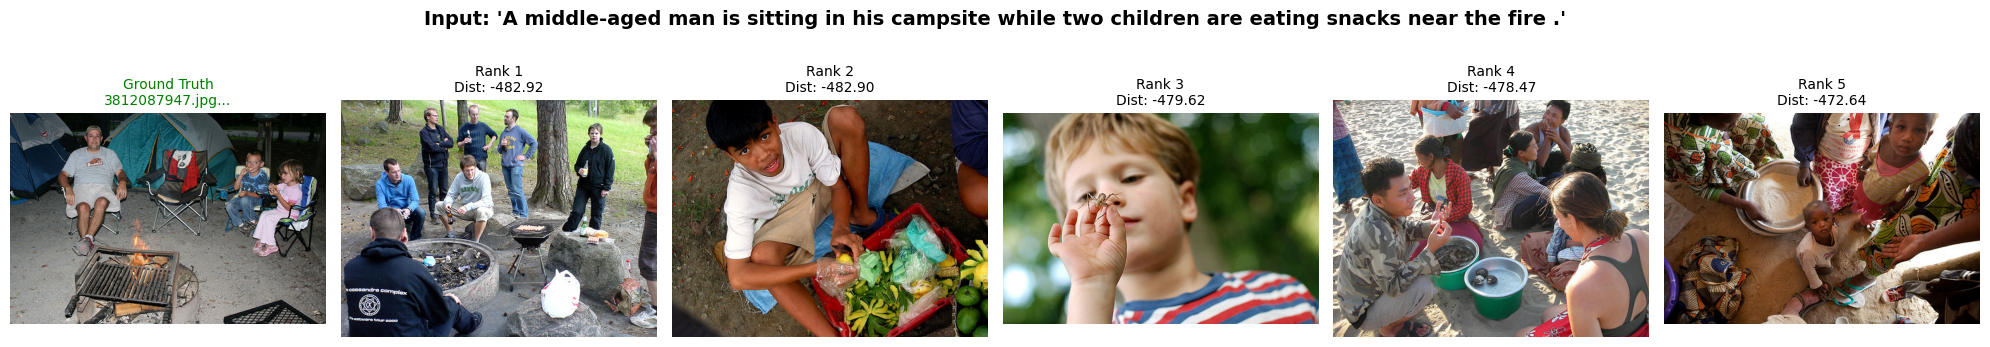

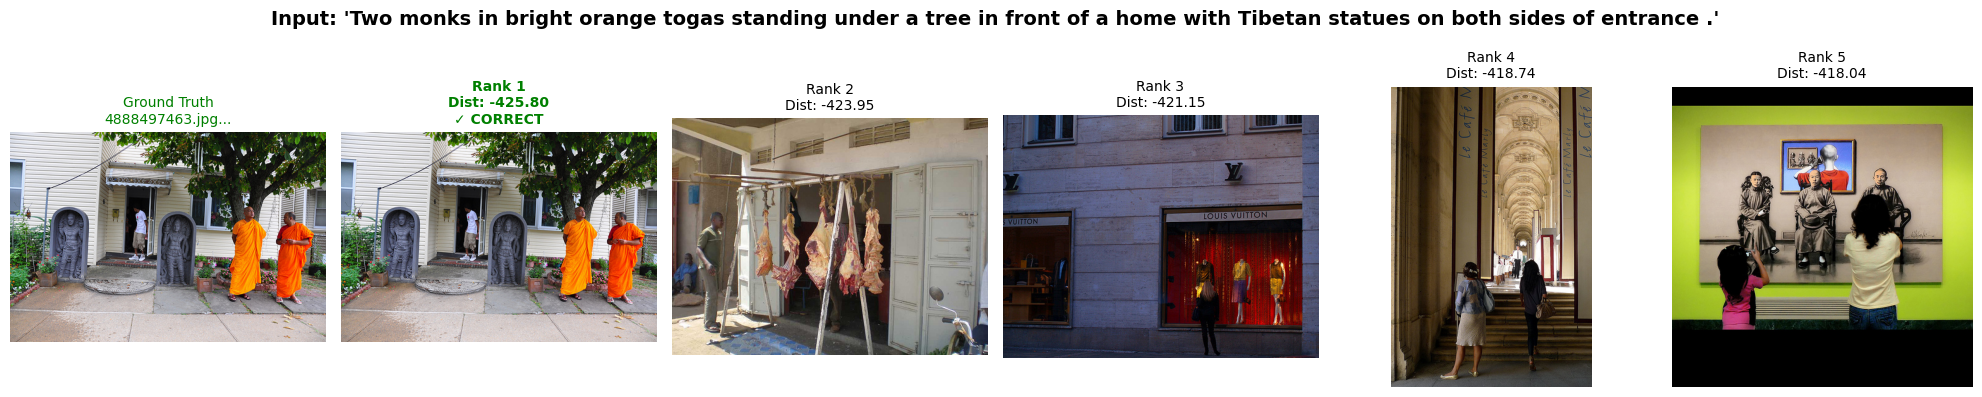

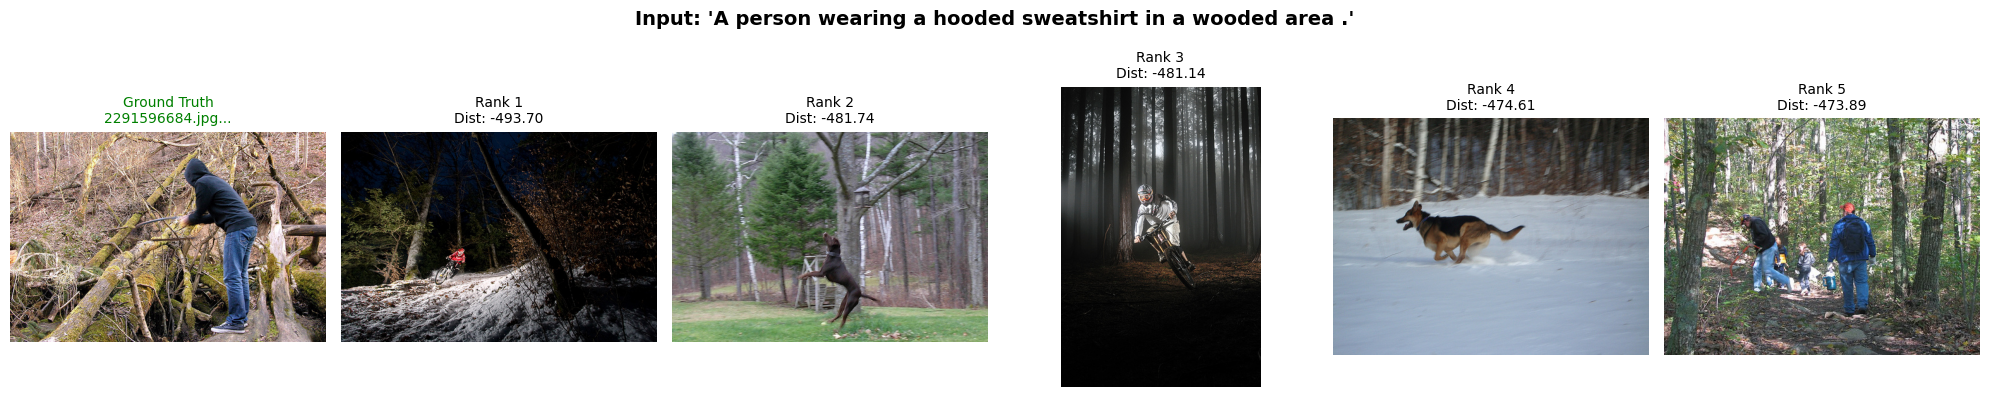

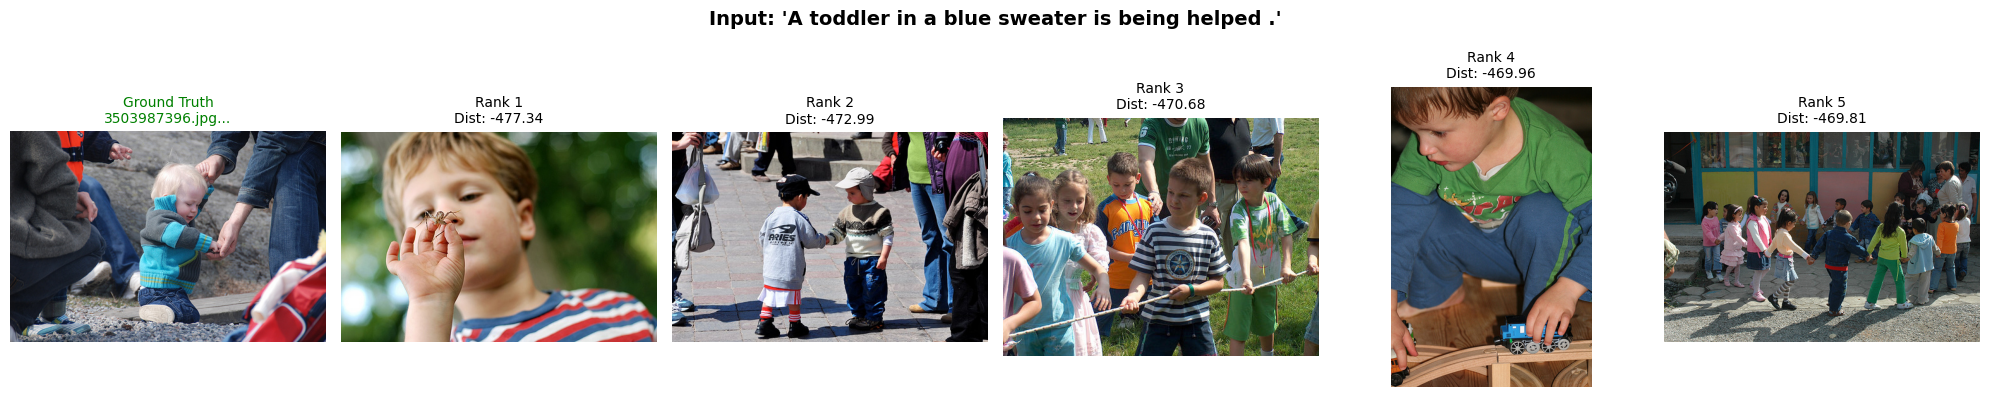

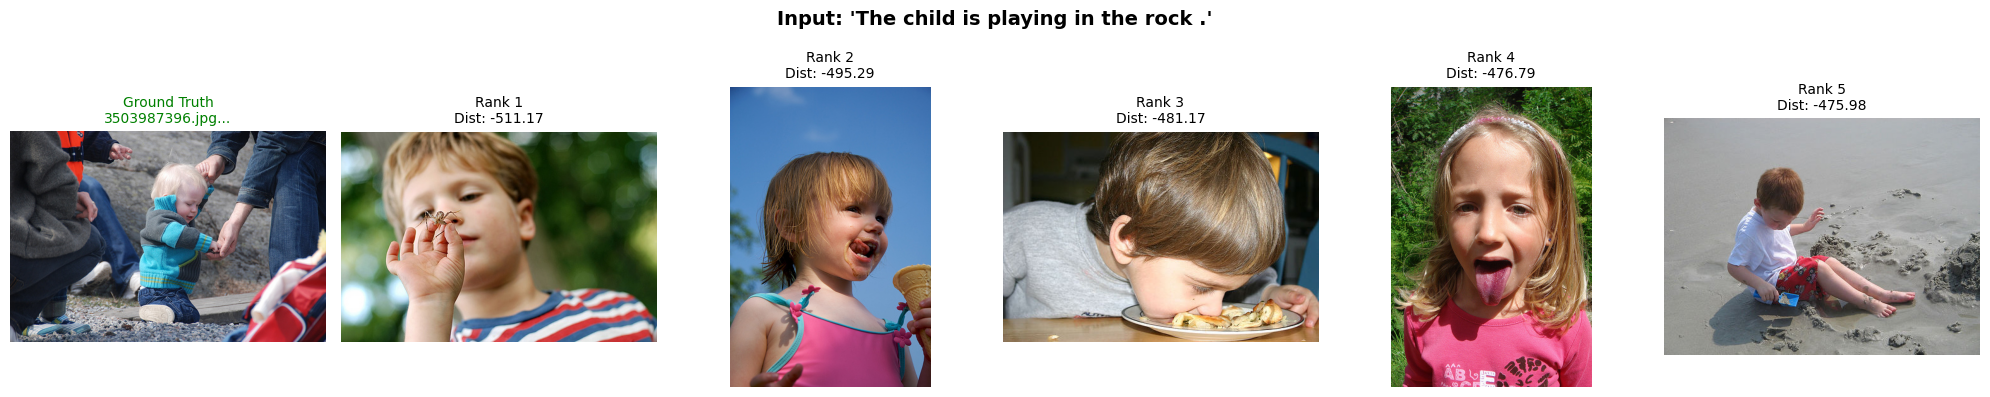

In [30]:
from challenge.src.eval import visualize_retrieval
import numpy as np
import torch

val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]

# Sample and visualize
for i in range(5):
    idx = np.random.randint(0, 100)
    caption_embd = val_text_embd[idx]
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]

    with torch.no_grad():
        pred_embds = model(caption_embd.to(DEVICE)).cpu()

        visualize_retrieval(
            pred_embds,
            gt_index,
            val_img_file,
            caption_text, val_img_embd, k=5)

## Submission

In [31]:
test_data = load_data("data/test/test.clean.npz")

test_embds = test_data['captions/embeddings']
test_embds = torch.from_numpy(test_embds).float()

with torch.no_grad():
    pred_embds = model(test_embds.to(DEVICE)).cpu()

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")

Generating submission file...
✓ Saved submission to submission.csv
Model saved to: models/mlp_baseline.pth
